**Recuerda que una vez abierto, Da clic en "Copiar en Drive", de lo contrario no podras almacenar tu progreso**

Nota: no olvide ir ejecutando las celdas de código de arriba hacia abajo para que no tenga errores de importación de librerías o por falta de definición de variables.

In [1]:
#configuración del laboratorio
# Ejecuta esta celda!
%load_ext autoreload
%autoreload 2
#for local 
#import sys ; sys.path.append('../commons/utils/')
!wget https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py -O general.py --no-cache
from general import configure_lab6
configure_lab6()
from lab6 import *
GRADER, x,y = part_1()

--2021-10-11 13:53:18--  https://raw.githubusercontent.com/jdariasl/ML_2020/master/Labs/commons/utils/general.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 14633 (14K) [text/plain]
Saving to: ‘general.py’

general.py          100%[===================>]  14.29K  --.-KB/s    in 0s      

2021-10-11 13:53:18 (45.7 MB/s) - ‘general.py’ saved [14633/14633]

lab configuration started
installing libraries
downloading files
lab configured


# Laboratorio 6 - Parte 1: Reducción de dimensión y Selección de características

Este ejercicio tiene como objetivo implementar varias técnicas de selección de características y usar regresion logisctica para resolver un problema de clasificación multiclase.

Para el problema de clasificación usaremos la siguiente base de datos: https://archive.ics.uci.edu/ml/datasets/Cardiotocography

Analice la base de datos, sus características, su variable de salida y el contexto del problema.

In [2]:
print('Dimensiones de la base de datos de entrenamiento. dim de x: ' + str(np.shape(x)) + '\tdim de y: ' + str(np.shape(y)))

Dimensiones de la base de datos de entrenamiento. dim de x: (2126, 22)	dim de y: (2126,)


**observación para las librerias sklearn **

Llamar explicitamente los parametros de las librerias de sklearn (e.j. si se quiere usar el parametro `kernel` del `SVC`, se debe llamar `SVC(kernel='rbf'`)

### Ejercicio 1: Entrenamiento sin selección de características

En nuestro primer ejercicio debemos completar la función para entrenar una SVM para resolver un problema de clasificación. Debemos completar siguiendo las recomendaciones:

1. Mantener los parámetros sugeridos de la regresión logística. 
2. Asignar el parametro de StratifiedKFold a los splits
3. Usar la area bajo la curva ROC como medida de error del modulo [metrics de sklearn](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.metrics). Tener en cuenta que esta función recibe un score, que es diferente a la predicción (explorar que metodo debemos usar para nuestro caso de problema y usar un estrategia One vs One).
4. Esta función la vamos a usar como base para comparar nuestros metodos de selección de características.

In [3]:
#ejercicio de código
def entrenamiento_sin_seleccion_caracteristicas(splits, X, Y):
    """
    Función que ejecuta el entrenamiento del modelo sin una selección particular
    de las características

      Parámetros:splits : numero de particiones  a realizar
      Retorna:
      1. El modelo entreando
      2. El vector de errores
      3. El Intervalo de confianza
      4. El tiempo de procesamiento
    """
    #Implemetamos la metodología de validación
    Errores = np.ones(splits)
    Score = np.ones(splits)
    times = np.ones(splits)
    j = 0
    kf = StratifiedKFold(n_splits= splits)
    for train_index, test_index in kf.split(X, Y):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = Y[train_index], Y[test_index]
        scaler = StandardScaler()
        
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
        #Creamos el clasificador SVM.
        clf = LogisticRegression(solver="liblinear", random_state=0)
        #Aquí se entran y se valida el modelo sin hacer selección de características
        ######
        # Entrenamiento el modelo.
        #Para calcular el costo computacional
        tiempo_i = time.time()
        clf.fit(X_train,y_train)
        # Validación del modelo
        Errores[j] = roc_auc_score(y_true=y_test, y_score=clf.predict_proba(X_test, ), multi_class= 'ovo')
        times[j] = time.time()-tiempo_i
        j+=1
    
    return clf, np.mean(Errores), np.std(Errores), np.mean(times)

In [4]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio1", entrenamiento_sin_seleccion_caracteristicas)

TEST EXITOSO!


In [5]:
#@markdown ¿Por que al la función que calcula la area sobre la curva roc se le debe pasar un parametro diferente que las predicciones?
respuesta_1 = "Se  le debe pasar este parametro diferente para especificarle que es un problema multiclase, si nos vamos a la libreria de roc_auc_score se menciona en el parametrio predict_proba que las estimaciones de probabilidad corresponden a la probabilidad de la clase con la etiqueta mayor para cada una de las clases de salida" #@param {type:"string"}

## Ejercicio 2: Entrenamiento con selección de características

La siguiente función "wrapper" nos permite hacer una selección de características utilizando la [librería recursive feature elimination de Sci-kit Learn](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html).

Esta libreria es un metodo de seleccion carcterisitcas wrapper, que usa los coeficientes derivados de  un estimador entrenado para estimar que caracteristicas tienen mayor poder predictivo.

Para completar debemos tener en cuenta lo siguiente:

1. Para el número de caractersiticas usar el parametro feature_numbers
2. Establecer el paso = 1 para ir eliminando las caracteristicas
3. Asumir que el estimador se crea externamente de la función
4. Entender los campos del RFE disponibles despues de entrenarlo para obtener:
    1. La mascara para saber que características fueron seleccionadas
    2. El ranking de las caracteristicas

In [6]:
#ejercicio de código
def recursive_feature_elimination_wrapper(estimator, feature_numbers, X,Y):
    """
    Esta función es un envoltorio del objeto RFE de sklearn

    Parámetros:
    estimator(sklearn.linear_model._logistic.LogisticRegression), El estimador LR
    feature_numbers(int), El número de características a considerar
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas

    Retorna:
    El modelo entrenado ()
    La máscara de características seleccionada, array [longitud de caracterisitcas de X]
    El rankeo de características, array [longitud de caracterisitcas de X]
    El objeto RFE entrenado sobre el set reducido de características
    El tiempo de ejecución
    """
    rfe = RFE(estimator=estimator, n_features_to_select=feature_numbers, step=1)
    tiempo_i = time.time()
    rfe.fit(X=X, y=Y)
    time_o = time.time()-tiempo_i
    feature_mask = rfe.support_
    features_rank = rfe.ranking_
    estimator = rfe.estimator_

    return rfe, feature_mask, features_rank, estimator, time_o

In [7]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio2", recursive_feature_elimination_wrapper)

TEST EXITOSO!


In [8]:
#@title Preguntas Abierta
#@markdown ¿Que diferencia tiene el metodo implementado con un metodo de filtro de selección de caracteristicas? explicar
respuesta_2 = 'El metodo de filtro no usa un algoritmo de machine learning para determinar si una caracteristica es buena o mala, en realidad usa una metrica para ver que atributos son irelevantes, a diferencia del metodo de Wrapper o envoltorio que si utiliza este algoritmo de machine learning, ademas usa el rendimiento de este algoritmo como criterio de aceptacion' #@param {type:"string"}

## Ejercicio 3:  Comparación de los resultados del modelo

Ahora en la siguiente función, vamos a usar la función planteada para realizar experimentos con la selección de características. Para ello:
1. Utilizar una metodología cross-validation estratificada.
2. Considerando n características, retorne el modelo entrenado, el vector de errores, el intervalo de confianza y el tiempo de ejecución.
3. Vamos a retornar un DataFrame con las siguientes columnas:
    - CON_SEL (indicando si se uso selección de caracteristicas)
    - NUM_VAR (número de selección de caracteristicas)
    - NUM_SPLITS  (número de particiones realizadas)
    - T_EJECUCION: tiempo de ejecucción
    - ERROR_VALIDACION
    - IC_STD_VALIDACION

4. En la primera fila del dataframe vamos a incluir la evaluación del modelo SVM sin selección de características (usando la función creada en el primer ejercicio) y sin particionar el set de datos.

In [9]:
#ejercicio de código
def experimentar(n_feats, n_sets, X, Y):
    """
    Esta función realiza la comparación del desempeño de RFE utilizando diferente 
    número de feats y particionando el conjunto de datos en diferente número de 
    subconjuntos

    Parámetros:
    X (numpy.array), El arreglo numpy de características
    Y (numpy.array), El vector de etiquetas
    n_feats, Vector de números enteros que indica el número de características
              que debe utilizar el modelo
    n_sets, Vector de números enteros que indica el número de particiones

    Retorna:  
    - DataFrame con las columnas: DESCRIPCION, T_EJECUCION ERROR_VALIDACION, 
    y IC_STD_VALIDACION 

    """
    df = pd.DataFrame()
    idx = 0
    for split_number in n_sets: 
    #Sin selección de características
        # se ignorar las otras salidas
        _,err,ic,t_ex = entrenamiento_sin_seleccion_caracteristicas(split_number, X,Y)  
        
        df.loc[idx,'CON_SEL'] = 'NO'
        df.loc[idx,'NUM_VAR'] = X.shape[1]
        df.loc[idx,'NUM_SPLITS'] = split_number
        df.loc[idx,'T_EJECUCION'] = t_ex
        df.loc[idx,'ERROR_VALIDACION'] = err
        df.loc[idx,'IC_STD_VALIDACION'] = ic
        idx+=1
    print("termina experimentos sin selección")
    #Con selección de características
    for f in n_feats:
        for split_number in n_sets:
            #Implemetamos la metodología de validación 
            Errores = np.ones(split_number)
            Score = np.ones(split_number)
            times = np.ones(split_number)
            kf = StratifiedKFold(n_splits=split_number)
            j = 0
            for train_index, test_index in kf.split(X,Y):
                
                X_train, X_test = X[train_index], X[test_index]
                y_train, y_test = Y[train_index], Y[test_index]
                scaler = StandardScaler()
                X_train = scaler.fit_transform(X_train)
                X_test = scaler.transform(X_test)
                
                lr =  LogisticRegression(solver="liblinear", random_state=0)
                
                # se ignorar las otras salidas
                rfe, _, _, _, t = recursive_feature_elimination_wrapper(estimator=lr,
                                                                        feature_numbers=f,
                                                                        X=X_train,
                                                                        Y=y_train)
                Errores[j]=roc_auc_score(y_true=y_test, y_score=rfe.predict_proba(X_test), multi_class='ovo')
                times[j] = t
                j+=1

            df.loc[idx,'CON_SEL'] = 'SI'
            df.loc[idx,'NUM_VAR'] = f
            df.loc[idx,'NUM_SPLITS'] = split_number
            df.loc[idx, 'T_EJECUCION'] = np.mean(times)
            df.loc[idx,'ERROR_VALIDACION'] = np.mean(Errores)
            df.loc[idx, 'IC_STD_VALIDACION'] = np.std(Errores)
            idx+=1
    return df


In [ ]:
## la funcion que prueba tu implementacion
GRADER.run_test("ejercicio3", experimentar)

termina experimentos sin selección
TEST EXITOSO!


In [ ]:
#@title Preguntas Abierta
#@markdown Describa la metodología de validación que se está aplicando.
respuesta_3 = 'Se esta utilizando la metodologia de validacion StratifiedKFold, donde primero se barajan los datos y se divide en n_splits = split_number partes, luego cada parte la utiliza como conjunto de prueba.' #@param {type:"string"}

Ejecuta la celda de codigo para realizar los experimentos

In [10]:
dfr = experimentar(n_feats = [3, 5, 10,15,20], n_sets = [3, 6], X= x, Y=y)

termina experimentos sin selección


Utilizando el *DataFrame* definido en la función anterior, retorne la mejor configuración del "Número de características" que resultó ,as beneficiosa. Identifique en términos de "Costo computacional" y "Eficiencia del Modelo".

In [ ]:
# podemos cambiar las forma de organizar el df para observar que diferencias hay
# cuando cambia  la prioridad alguno de los dos parámetros
dfr.sort_values(['T_EJECUCION', "ERROR_VALIDACION"], ascending=[False, True])

,CON_SEL,NUM_VAR,NUM_SPLITS,T_EJECUCION,ERROR_VALIDACION,IC_STD_VALIDACION
3,SI,3.0,6.0,0.333673,0.895617,0.078379
5,SI,5.0,6.0,0.315194,0.932506,0.042592
2,SI,3.0,3.0,0.267229,0.918087,0.045298
7,SI,10.0,6.0,0.262940,0.938146,0.031042
4,SI,5.0,3.0,0.259470,0.926323,0.054468
6,SI,10.0,3.0,0.211055,0.938896,0.037052
9,SI,15.0,6.0,0.183512,0.954878,0.031404
8,SI,15.0,3.0,0.146346,0.952058,0.030071
11,SI,20.0,6.0,0.079543,0.953329,0.032467
10,SI,20.0,3.0,0.063606,0.951240,0.028298


Veamos como se relaciona el tiempo de ejecución con los splits y la selección de caracteristicas

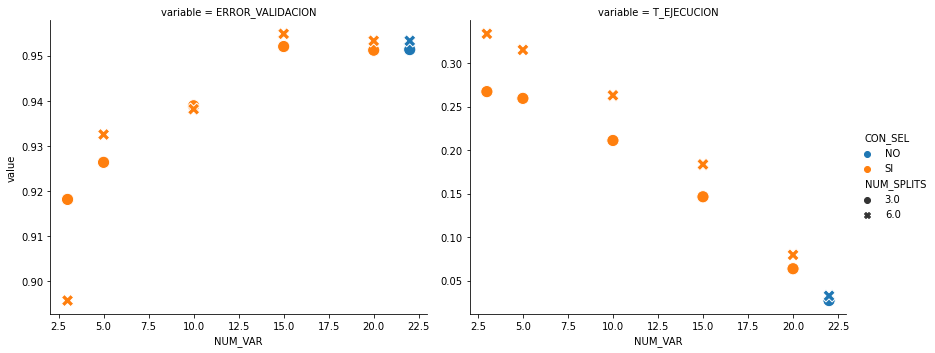

In [ ]:
import seaborn as sns
d_toplot = pd.melt(dfr,id_vars=['CON_SEL', 'NUM_VAR', 'NUM_SPLITS'], value_vars=['ERROR_VALIDACION', 'T_EJECUCION'])
sns.relplot(data = d_toplot, x = 'NUM_VAR', y = 'value', hue = 'CON_SEL', style = 'NUM_SPLITS', col = 'variable', kind='scatter', facet_kws = {'sharey' : False}, aspect=1.2,s=150)

In [ ]:
#@title Pregunta Abierta
#@markdown ¿Que relación observa entre tiempo de ejecución, el desempeño del modelo y el número de caracteristicas? Explicar con base a los resultados
respuesta_4 = "\"A medida que el numero de caracteristicas aumenta, el desempe\\xF1o del modelo \\\"error_validacion\\\" mejora acerc\\xE1ndose cada vez mas a 1.0 y el tiempo de ejecucion disminuye.\"" #@param {type:"string"}

Ahora use el mejor modelo para entrenar nuevamente el y saber que caracteristicas tienen el mejor poder predictivo. Use el # de caracteristicas que resulto mejor cuando se realizo alguna selección de caracteristicas.

In [ ]:
# observemos el mejor modelo cuando se realizo selección de caracteristicas
dfr[dfr['CON_SEL'] == 'SI'].sort_values(["ERROR_VALIDACION"], ascending=[False]).head(1)

,CON_SEL,NUM_VAR,NUM_SPLITS,T_EJECUCION,ERROR_VALIDACION,IC_STD_VALIDACION
9,SI,15.0,6.0,0.183512,0.954878,0.031404


In [ ]:
lr =  LogisticRegression(solver="liblinear", random_state=0)
rfe, feature_mask, _, _, _ = recursive_feature_elimination_wrapper(lr, 15, x,y)
print("esta es la mascara (deberia ser solo valores True y False) \n", feature_mask)

esta es la mascara (deberia ser solo valores True y False) 
 [ True  True False  True  True  True  True  True  True False False False
 False False  True  True  True  True  True False  True  True]


In [ ]:
#@title Pregunta Abierta
#@markdown Utilizando los resultados obtenidos, sí en algún momento se debe prescindir de algunas de las variables para realizar el diagnóstico, ¿cuáles se podrían sugerir como candidatas menos importantes al personal médico ?
respuesta_5 = "Las variables candidatas en base a los resultados serian la variable que estan en False cuando se imprime la mascara \"feature_mask\", y comparando con las variables de Repositorio se evidencia que dichas variables serian: #3 \"FM - # of fetal movements per second\" - #10 \"ALTV - percentage of time with abnormal long term variability\" - #11 \"MLTV - mean value of long term variability\" - #12 \"Width - width of FHR histogram\" - #13 \"Min - minimum of FHR histogram\" - #14 \"Max - Maximum of FHR histogram\" - #20 \"Variance - histogram variance\"" #@param {type:"string"}

In [ ]:
GRADER.check_tests()

Todo se ve ok. Asegurate de responder las preguntas abiertas y envia le archivo al formulario ¡buen trabajo!


In [ ]:
#@title Integrantes
codigo_integrante_1 ='1000415078' #@param {type:"string"}
codigo_integrante_2 = '1035833769'  #@param {type:"string"}

----
esta linea de codigo va fallar, es de uso exclusivo de los profesores


In [ ]:
GRADER.grade()

uso del docente
